# Toy example

This notebook illustrates several variants of the (Bayesian) logistic regression classifier on a 2-D toy example. This notebook includes:

* Standard logistic regression
* Bayesian logistic regression with isotropic prior covariance
* Bayesian logistic regression with full prior covariance

In [1]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', family="serif", serif="Times", size=6)
rc('text.latex', preamble=r'\usepackage{bm}\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}')

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from bayesian_logistic_regression.variational_approximation import VariationalLogisticRegressionIsotropicPrior, VariationalLogisticRegressionFullCovariancePrior
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML
from scipy import stats
from tqdm.auto import tqdm


display(HTML("<style>.container { width:90% !important; }</style>"))


cmap = "viridis"
markersize = 5

Define some helper methods for visualization purposes.

In [2]:
def plot_posterior_draws(mean, cov, x_min, x_max, ax, fit_intercept, num_draws=10, **kwargs):
    """
    Draw from the weight posterior and draw the corresponding decision boundary.
    """
    
    # Sample weights from weight posterior
    w_draws = np.random.multivariate_normal(mean=mean, cov=cov, size=num_draws)

    for draw in range(num_draws):
        w = w_draws[draw]

        # Calculate two points on the decision boundary
        if fit_intercept:
            y_x_min = (-w[0] - w[1] * x_min) / w[2]
            y_x_max = (-w[0] - w[1] * x_max) / w[2]
        else:
            y_x_min = -w[0] * x_min / w[1]
            y_x_max = -w[0] * x_max / w[1]

        # Draw decision boundary
        ax.plot([x_min, x_max], [y_x_min, y_x_max], **kwargs)


def draw_predictive_mean(X_train, y_train, X_test, y_pred, ax):
    """
    Visualize the predictive mean
    """
    
    # contourf(..., levels): Draw lines at specificed levels
    im = ax.contourf(X_test[:, :, 0],
                     X_test[:, :, 1],
                     y_pred,
                     levels=np.linspace(0, 1.0, 11),
                     cmap=cmap,
                     alpha=0.2)

    # Plot the training samples
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=markersize, cmap=cmap)

    # Place colorbar next to subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)

    ax.set_xlim(X_test[:, :, 0].min(), X_test[:, :, 0].max())
    ax.set_ylim(X_test[:, :, 1].min(), X_test[:, :, 1].max())
    ax.set_aspect('equal', adjustable='box')
    
    for c in im.collections:
        c.set_edgecolor("face")
        
    cbar.solids.set_edgecolor("face")
    

def draw_predictive_variance(X_train, y_train, X_test, y_var, ax, subsample_y_ticks=False):
    """
    Visualize the predictive variance
    """
    
    # Visualize predictive variance at all locations in the feature space
    im = ax.contourf(
        X_test[:, :, 0],
        X_test[:, :, 1],
        y_var,
        np.linspace(y_var.min(), y_var.max(), 10),
        cmap="Greens",
        alpha=0.5)

    # Plot the training samples
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, s=markersize)

    # Place colorbar next to subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
    if subsample_y_ticks:
        cbar.set_ticks(cbar.get_ticks()[::2])
    
    format_str = "{:3.2f}" if cbar.get_ticks()[-1] > 0.01 else "{:.0e}"
    cax.set_yticklabels([format_str.format(i) if ~np.isclose(i, 0) else "0" for i in cbar.get_ticks()])
    ax.set_aspect("equal", adjustable="box")

    for c in im.collections:
        c.set_edgecolor("face")
    
    cbar.solids.set_edgecolor("face")
        
    return cax, cbar

In [3]:
def draw_figure(X_train, y_train, X_test, y_pred, y_var, posterior_w_mean, posterior_w_var, prior_w_mean, prior_w_var):
    """
    Create a figure with three subplots:
        0: Decision boundaries corresponding to draws from weight posterior and prior
        1: Predictive mean
        2: Predictive variance
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(7.0625, 2))

    #
    # Subplot 0: Draws from the predictive distribution
    #
    plot_kwargs = {
        "alpha": 1.0,
        "linewidth": 1,
    }
    
    # Plot draws from the posterior
    plot_posterior_draws(mean=posterior_w_mean,
                         cov=posterior_w_var,
                         x_min=X_test[:, :, 0].min(),
                         x_max=X_test[:, :, 0].max(),
                         ax=axes[0],
                         fit_intercept=False,
                         color="r",
                         num_draws=20,
                         **plot_kwargs)
    
    # Plot draws from the prior
    plot_posterior_draws(mean=prior_w_mean,
                         cov=prior_w_var,
                         x_min=X_test[:, :, 0].min(),
                         x_max=X_test[:, :, 0].max(),
                         ax=axes[0],
                         fit_intercept=False,
                         color="b",
                         num_draws=20,
                         linestyle="dotted",
                         **plot_kwargs)
    
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, s=markersize)
    axes[0].set_xlim(X_test[:, :, 0].min(), X_test[:, :, 0].max())
    axes[0].set_ylim(X_test[:, :, 1].min(), X_test[:, :, 1].max())
    axes[0].set_title("Draws from weight posterior and prior")
    axes[0].set_aspect("equal", adjustable="box")
    
    #
    # Subplot 1: Posterior probability
    #
    draw_predictive_mean(X_train, y_train, X_test, y_pred, axes[1])
    axes[1].set_title(r"Predictive mean") #  $p(\mathcal{C}_1 | \bm{x}^*)$

    #
    # Subplot 2: Predictive variance
    #
    cax, cbar =  draw_predictive_variance(X_train, y_train, X_test, y_var, axes[2])
    axes[2].set_title("Predictive variance")
    cax.set_yticklabels(["{:3.2f}".format(i) if ~np.isclose(i, 0) else "0" for i in cbar.get_ticks()])
        
    fig.tight_layout()
    
    return fig, axes

# Data

Create a 2-D toy dataset for binary classification.

In [4]:
np.random.seed(12346)

def create_toy_data():
    x0 = 1.2 * np.random.normal(size=50).reshape(-1, 2) - np.array([-10, 5])
    x1 = 1.2 * np.random.normal(size=50).reshape(-1, 2) + np.array([-10, 5])
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

X_train, y_train = create_toy_data()

# Standard Logistic Regression

In [5]:
model = LogisticRegression(fit_intercept=False, max_iter=1000, C=0.1)
scaler = StandardScaler(with_mean=True, with_std=False).fit(X_train)
X_train_transformed = scaler.transform(X_train)
model.fit(X_train_transformed, y_train)

x1_test, x2_test = np.meshgrid(np.linspace(-20, 20, 1000), np.linspace(-20, 20, 1000))
X_test = np.array([x1_test, x2_test]).reshape(2, -1).T
X_test_transformed = scaler.transform(X_test)

y = model.predict_proba(X_test_transformed)

Single subplot.

<IPython.core.display.Javascript object>


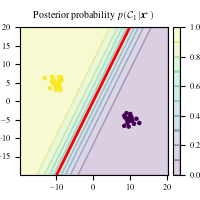

In [6]:
fig, ax = plt.subplots(1, figsize=(2, 2))

draw_predictive_mean(X_train=X_train_transformed,
                     y_train=y_train,
                     X_test=X_test_transformed.reshape(x1_test.shape + (2,)),
                     y_pred=y[:, 1].reshape(len(x1_test), len(x2_test)),
                     ax=ax)

ax.set_title(r"Posterior probability $p(\mathcal{C}_1 | \bm{x}^*)$")

# Draw the decision boundary
w = model.coef_[0]
x_min = X_test_transformed[:, 0].min()
x_max = X_test_transformed[:, 0].max()
y_x_min = -w[0] * x_min / w[1]
y_x_max = -w[0] * x_max / w[1]

ax.plot([x_min, x_max], [y_x_min, y_x_max], alpha=1.0, linewidth=2, color="r")

fig.subplots_adjust(left=0.1, bottom=0.09, right=0.90, top=0.90, wspace=0.3, hspace=0.2)
fig.savefig("/tmp/toy_example_standard_logistic_regression.pdf", dpi=300)

Separate subplots for decision boundary and predictive mean.

<IPython.core.display.Javascript object>


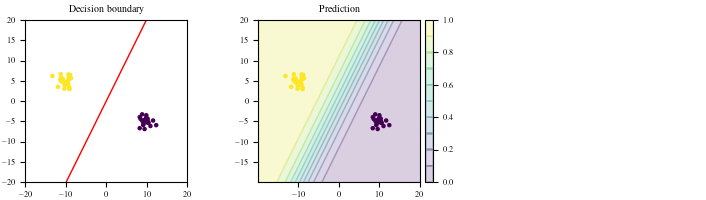

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(7.0625, 2))

#
# Subplot 0: Decision boundary
#

axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, s=markersize)

# Draw the decision boundary
w = model.coef_[0]
x_min = X_test_transformed[:, 0].min()
x_max = X_test_transformed[:, 0].max()
y_x_min = -w[0] * x_min / w[1]
y_x_max = -w[0] * x_max / w[1]

axes[0].plot([x_min, x_max], [y_x_min, y_x_max], alpha=1.0, linewidth=1, color="r")

axes[0].set_xlim(X_test[:, 0].min(), X_test[:, 0].max())
axes[0].set_ylim(X_test[:, 1].min(), X_test[:, 1].max())
axes[0].set_aspect("equal", adjustable="box")
axes[0].set_title("Decision boundary")

#
# Subplot 1: Predictive mean
#
draw_predictive_mean(X_train=X_train_transformed,
                     y_train=y_train,
                     X_test=X_test_transformed.reshape(x1_test.shape + (2,)),
                     y_pred=y[:, 1].reshape(len(x1_test), len(x2_test)),
                     ax=axes[1])

axes[1].set_title("Prediction")

#
# Subplot 2: Disabled for now
#
axes[2].set_axis_off()
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.axis("off")

fig.subplots_adjust(left=0.02, bottom=0.09, right=0.96, top=0.90, wspace=0.3, hspace=0.2)
fig.savefig("/tmp/toy_example_standard_logistic_regression_decision_boundary.pdf", dpi=300)

# Bayesian Logistic Regression with Variational Approximation

## Isotropic prior

Set up logistic regression model.

In [8]:
model = VariationalLogisticRegressionIsotropicPrior(alpha=1e0, fit_intercept=False)

scaler = StandardScaler(with_mean=True, with_std=False).fit(X_train)
X_train_transformed = scaler.transform(X_train)

model.fit(X_train_transformed, y_train, max_iter=1000, verbose=False)

x1_test, x2_test = np.meshgrid(np.linspace(-20, 20, 1000), np.linspace(-20, 20, 1000))
X_test = np.array([x1_test, x2_test]).reshape(2, -1).T
X_test_transformed = scaler.transform(X_test)

y, y_var = model.predict_draws(X_test_transformed, num_monte_carlo_draws=100)

Visualize the predictions.

<IPython.core.display.Javascript object>


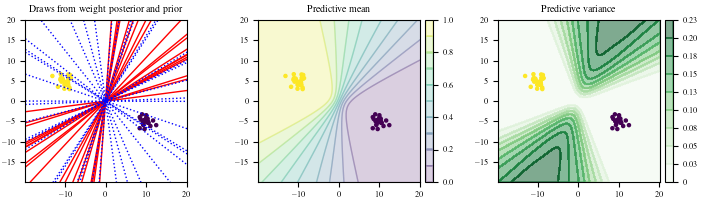

In [9]:
fig, axes = draw_figure(
    X_train=X_train_transformed,
    y_train=y_train,
    X_test=X_test_transformed.reshape(x1_test.shape + (2,)),
    y_pred=y.reshape(len(x1_test), len(x2_test)),
    y_var=y_var.reshape(len(x1_test), len(x2_test)),
    posterior_w_mean=model.w_mean,
    posterior_w_var=model.w_var,
    prior_w_mean=np.zeros_like(model.w_mean),
    prior_w_var=1. / model.alpha * np.eye(2),
)

fig.subplots_adjust(left=0.02, bottom=0.09, right=0.96, top=0.90, wspace=0.3, hspace=0.2)
fig.savefig("/tmp/toy_example_isotropic_prior_only_posterior.pdf", dpi=300)

## Full covariance prior

In [10]:
prior_w_var_inv = 1 * np.cov(X_train, rowvar=False) + 1e-5 * np.eye(2)
model = VariationalLogisticRegressionFullCovariancePrior(prior_w_var_inv=prior_w_var_inv, fit_intercept=False)

scaler = StandardScaler(with_mean=True, with_std=False).fit(X_train)
X_train_transformed = scaler.transform(X_train)

model.fit(X_train_transformed, y_train, max_iter=1000, verbose=True)

x1_test, x2_test = np.meshgrid(np.linspace(-20, 20, 1000), np.linspace(-20, 20, 1000))
X_test = np.array([x1_test, x2_test]).reshape(2, -1).T
X_test_transformed = scaler.transform(X_test)

y, y_var = model.predict_draws(X_test_transformed, num_monte_carlo_draws=100)

[0000] Lower bound = -15.306
[0001] Lower bound = -12.180
[0002] Lower bound = -10.814
[0003] Lower bound = -10.124
[0004] Lower bound = -9.748
[0005] Lower bound = -9.537
[0006] Lower bound = -9.415
[0007] Lower bound = -9.344
[0008] Lower bound = -9.302
[0009] Lower bound = -9.277
[0010] Lower bound = -9.263
[0011] Lower bound = -9.254
[0012] Lower bound = -9.249
[0013] Lower bound = -9.246
[0014] Lower bound = -9.244
[0015] Lower bound = -9.243
[0016] Lower bound = -9.242
[0017] Lower bound = -9.242
[0018] Lower bound = -9.242
[0019] Lower bound = -9.242


<IPython.core.display.Javascript object>


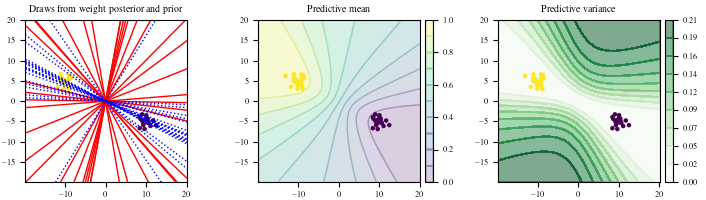

In [11]:
fig, axes = draw_figure(
    X_train=X_train_transformed,
    y_train=y_train,
    X_test=X_test_transformed.reshape(x1_test.shape + (2,)),
    y_pred=y.reshape(len(x1_test), len(x2_test)),
    y_var=y_var.reshape(len(x1_test), len(x2_test)),
    posterior_w_mean=model.w_mean,
    posterior_w_var=model.w_var,
    prior_w_mean=np.zeros_like(model.w_mean),
    prior_w_var=model.prior_w_var,
)

fig.subplots_adjust(left=0.02, bottom=0.09, right=0.96, top=0.90, wspace=0.3, hspace=0.2)
fig.savefig("/tmp/toy_example_full_covariance_prior.pdf", dpi=300)